##### This requires the DBTL0_Top3 file

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import ttest_ind
from adjustText import adjust_text

# Load the data files

DBTL0_Top3 = pd.read_csv('DBTL0_Top3.csv')  # Replace with your actual file names
name_df = pd.read_csv('proteomics_id_translator_240305.csv')  # Assuming a file with 'original' and 'locus' columns

In [2]:
# Create a dictionary from the name_df for fast lookup
translator_dict = pd.Series(name_df['locus'].values, index=name_df['extracted']).to_dict()

# Use the dictionary to map the Protein.Group names to locus names
DBTL0_Top3['Protein.Group'] = DBTL0_Top3['Protein.Group'].map(lambda x: translator_dict.get(x, x))

# Count the number of non-translated protein groups
nontranslated = DBTL0_Top3['Protein.Group'].apply(lambda x: x not in translator_dict.values()).sum()
print(f"In total, N = {nontranslated}/{len(DBTL0_Top3['Protein.Group'])} proteins were not translated to locus names")

In total, N = 0/784056 proteins were not translated to locus names


### Initialize a DataFrame to store log2 and log10 values for all samples

In [3]:
 log2_log10_results = pd.DataFrame()

sample_control_pairs = {
    'PP_0812': 'Control',
    'PP_0813': 'Control',
    'PP_0814': 'Control',
    'PP_0815': 'Control',
    'PP_0751': 'Control',
    'PP_0528': 'Control',
    'PP_0368': 'Control',
}

In [4]:
# log2_log10_results = pd.DataFrame()

# sample_control_pairs = {
#     'PRT1093_PP_0528_PP_0751_PP_0812_PP_0815': 'PRT1093_Control',
#     'PRT1093_PP_0528_PP_0751_PP_0813_PP_0815': 'PRT1093_Control',

#     'PRT1093_PP_0368_PP_0751_PP_0813_PP_0815': 'PRT1093_Control',
#     'PRT1093_PP_0368_PP_0751_PP_0814_PP_0815': 'PRT1093_Control',
# }

In [5]:
# log2_log10_results = pd.DataFrame()
# sample_control_pairs = {
#     'PP_0368_PP_0751_PP_0812_PP_0815': 'Control',
    
#     'PP_0368_PP_0751_PP_0813': 'Control',
# #    'PP_0368_PP_0751_PP_0814': 'Control',
#     'PP_0368_PP_0751_PP_0812': 'Control',
# }

In [6]:
# Define thresholds for filtering
log2_fold_change_threshold = 0
p_value_threshold = 0.05

Filtered Log2 and Log10 values saved to 'dbtl0_filtered_log2_log10_values_by_significance.csv'


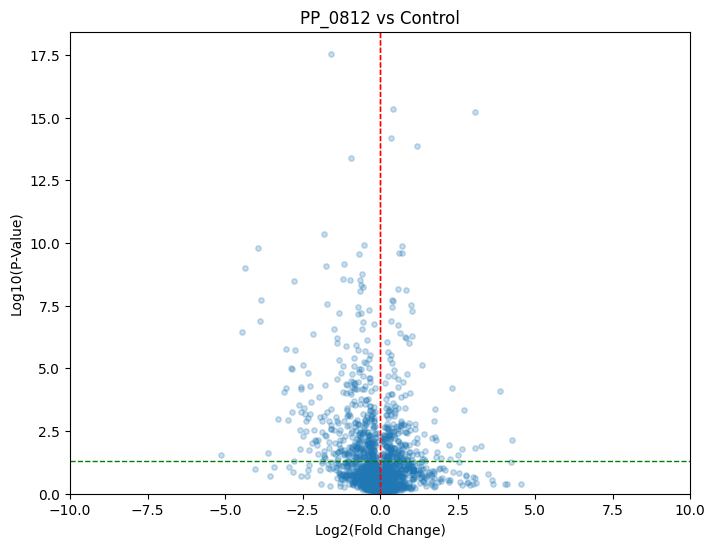

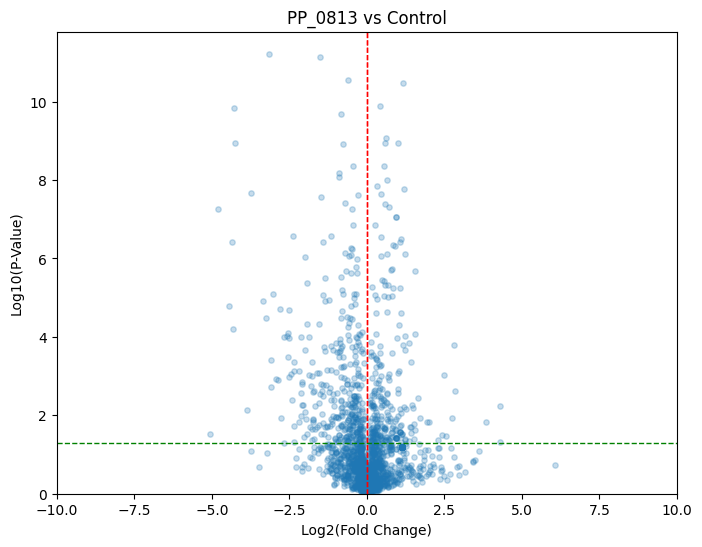

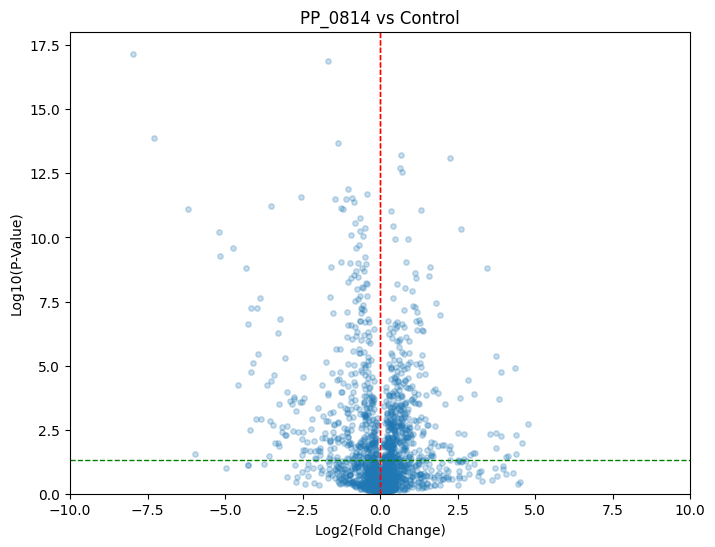

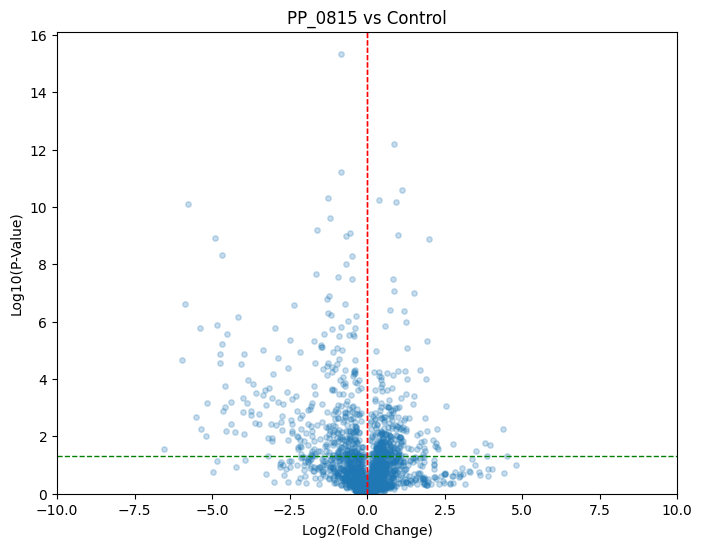

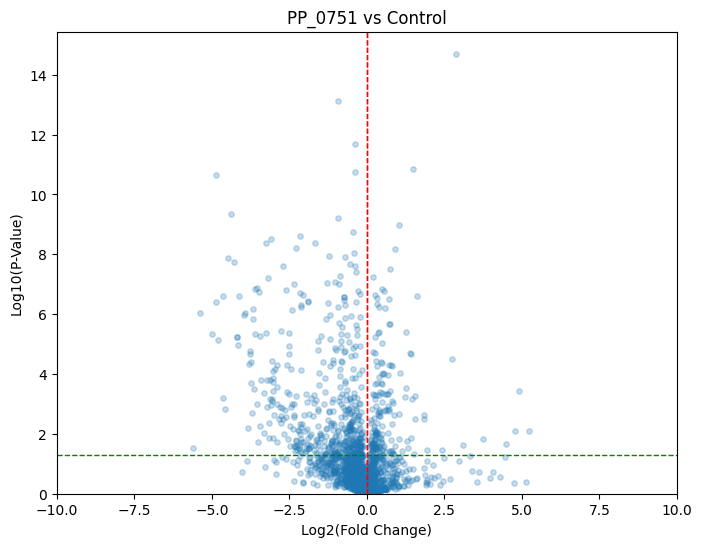

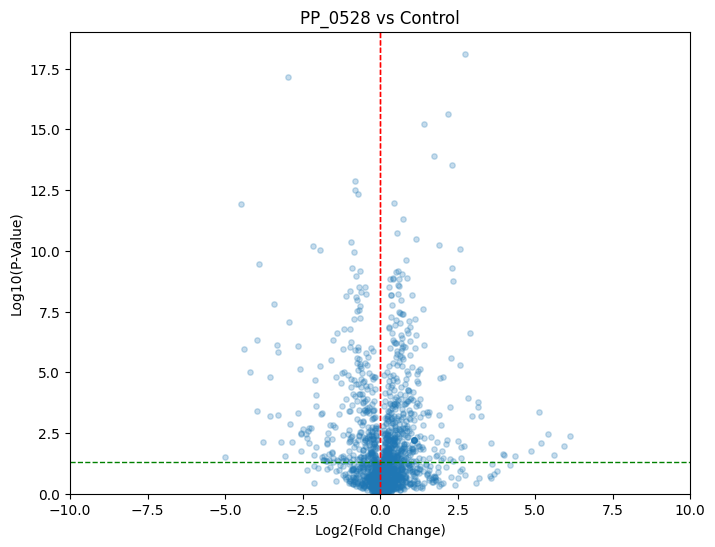

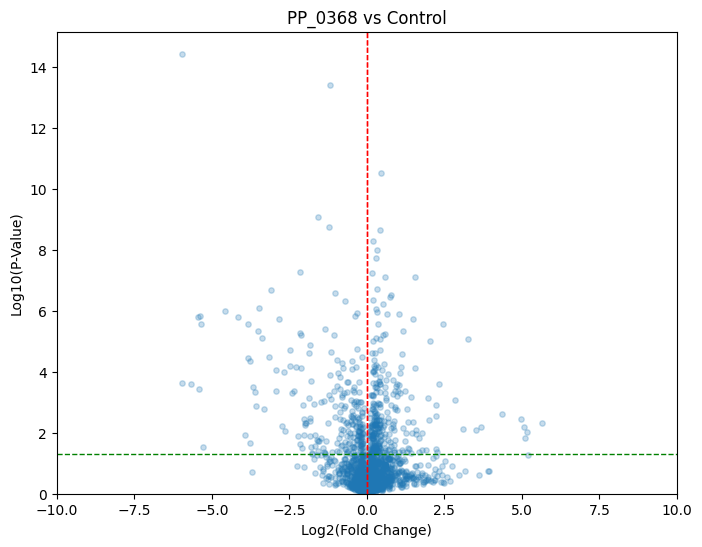

In [8]:
# Define replicates to include for specific samples
replicates_to_include = ['R4', 'R5', 'R6']

for sample, control in sample_control_pairs.items():
    # Filter data for the current sample and its control
    if sample in ['PP_0812', 'PP_0813']:
        sample_data = DBTL0_Top3[(DBTL0_Top3['Sample'] == sample) & (DBTL0_Top3['Replicate'].isin(replicates_to_include))]
    else:
        sample_data = DBTL0_Top3[DBTL0_Top3['Sample'] == sample]
    
    control_data = DBTL0_Top3[DBTL0_Top3['Sample'] == control]

    # Debug: Check if data is loaded correctly
    if sample_data.empty or control_data.empty:
        print(f"No data for {sample} or {control}")
        continue
    # Compute mean %_of protein_abundance_Top3-method for each protein
    sample_mean = sample_data.groupby('Protein.Group')['%_of protein_abundance_Top3-method'].mean().reset_index()
    control_mean = control_data.groupby('Protein.Group')['%_of protein_abundance_Top3-method'].mean().reset_index()

    # Rename columns for clarity
    sample_mean.rename(columns={'%_of protein_abundance_Top3-method': 'sample_abundance'}, inplace=True)
    control_mean.rename(columns={'%_of protein_abundance_Top3-method': 'control_abundance'}, inplace=True)

    # Merge the data on Protein.Group
    merged_data = pd.merge(sample_mean, control_mean, on='Protein.Group', how='outer')

    # Calculate log2 fold change (fill missing values with NaN)
    merged_data['log2_change'] = np.log2(merged_data['sample_abundance'] / merged_data['control_abundance'])

    # Debug: Check if log2_change contains NaN values
    if merged_data['log2_change'].isna().all():
        print(f"All log2 fold changes are NaN for {sample} vs {control}")
        continue

    # Compute p-values (assume replicates data exists for actual p-value calculation)
    sample_reps = sample_data[['Protein.Group', '%_of protein_abundance_Top3-method']]
    control_reps = control_data[['Protein.Group', '%_of protein_abundance_Top3-method']]

    p_values = []
    for protein in merged_data['Protein.Group']:
        group1 = sample_reps[sample_reps['Protein.Group'] == protein]['%_of protein_abundance_Top3-method']
        group2 = control_reps[control_reps['Protein.Group'] == protein]['%_of protein_abundance_Top3-method']
        if not group1.empty and not group2.empty:
            _, p_val = ttest_ind(group1, group2, equal_var=False)
        else:
            p_val = np.nan
        p_values.append(p_val)

    # Add p-values and log10 transformation
    merged_data['p_value'] = p_values
    merged_data['log10_p_value'] = -np.log10(merged_data['p_value'])

    # Debug: Check if log10_p_value contains NaN values
    if merged_data['log10_p_value'].isna().all():
        print(f"All log10 p-values are NaN for {sample} vs {control}")
        continue

    # Filter based on plotting criteria
    filtered_data = merged_data[
        (merged_data['log2_change'].abs() > log2_fold_change_threshold) &
        (merged_data['log10_p_value'] > -np.log10(p_value_threshold))
    ]

    # Store filtered results in log2_log10_results
    if log2_log10_results.empty:
        log2_log10_results = filtered_data[['Protein.Group', 'log2_change', 'log10_p_value']].copy()
        log2_log10_results.rename(
            columns={'log2_change': f'{sample}_log2_FC', 'log10_p_value': f'{sample}_log10_pval'},
            inplace=True
        )
    else:
        temp_results = filtered_data[['Protein.Group', 'log2_change', 'log10_p_value']].copy()
        temp_results.rename(
            columns={'log2_change': f'{sample}_log2_FC', 'log10_p_value': f'{sample}_log10_pval'},
            inplace=True
        )
        log2_log10_results = pd.merge(
            log2_log10_results,
            temp_results,
            left_on='Protein.Group',
            right_on='Protein.Group',
            how='outer'
        )

    # Create volcano plot for the current sample
    fold_change = merged_data['log2_change']
    p_values = merged_data['log10_p_value']

    plt.figure(figsize=(8, 6))
    plt.scatter(fold_change, p_values, s=15, alpha=0.25)
    plt.title(f"{sample} vs {control}")
    plt.xlabel("Log2(Fold Change)")
    plt.ylabel("Log10(P-Value)")
    plt.grid(False)
    plt.ylim(0,)
    plt.xlim(-10, 10)

    # Threshold lines
    plt.axvline(x=log2_fold_change_threshold, color='r', linestyle='--', linewidth=1)
    plt.axvline(x=-log2_fold_change_threshold, color='r', linestyle='--', linewidth=1)
    plt.axhline(y=-np.log10(p_value_threshold), color='g', linestyle='--', linewidth=1)

    # Annotate significant points
#     texts = []
#     labels = merged_data['Protein.Group']
#     for i, label in enumerate(labels):
#         if (fold_change[i] > log2_fold_change_threshold or fold_change[i] <-log2_fold_change_threshold) and p_values[i] > -np.log10(p_value_threshold):
#             text = plt.text(fold_change[i], p_values[i], label, fontsize=10)
#             texts.append(text)

#     if texts:
#         adjust_text(texts, arrowprops=dict(arrowstyle='-', color='red', lw=1))

    # Show the plot
     #plt.show()

# Save the filtered log2 and log10 values to a CSV file
log2_log10_results.to_csv('dbtl0_filtered_log2_log10_values_by_significance.csv', index=False)
print("Filtered Log2 and Log10 values saved to 'dbtl0_filtered_log2_log10_values_by_significance.csv'")

#### Investigating genes that are upregulated amongst a subset of samples

In [40]:
samples_of_interest = ["PP_0812", "PP_0813", "PP_0814"]

#### TCA Cycle

In [52]:
# Define the second list of proteins
proteins_txt = pd.read_csv('pathway-genes-TCA.txt', delimiter='\t')  # Adjust the separator if needed
proteins_txt = proteins_txt.drop_duplicates(subset='Gene Accession')
second_list = proteins_txt['Gene Accession'].tolist()

# Filter the data to include only the proteins that are significant for all samples of interest
filtered_data = log2_log10_results.dropna(subset=[f"{sample}_log2_FC" for sample in samples_of_interest] + [f"{sample}_log10_pval" for sample in samples_of_interest])

# Compare the filtered data against the second list of proteins
matching_proteins = filtered_data[filtered_data['Protein.Group'].isin(second_list)]
matching_proteins.to_csv('matching_proteins.csv', index=False)

# Calculate the ratio of significantly changed genes
included = matching_proteins.shape[0]
total = len(second_list)
ratio = included / total

print(f"{included} out of {total} genes in the TCA cycle were significantly changed across strains")
merged_data = pd.merge(matching_proteins, proteins_txt, left_on='Protein.Group', right_on='Gene Accession')

# Extract relevant columns
columns_to_include = ['Gene Accession', 'Gene name', 'Enzymatic activity'] + [f"{sample}_log2_FC" for sample in samples_of_interest] + [f"{sample}_log10_pval" for sample in samples_of_interest]
locus_genes = merged_data[columns_to_include].drop_duplicates(subset='Gene Accession')

# Print the genes by locus with additional information
print("Those genes were:")
print(locus_genes.to_string(index=False))

7 out of 21 genes in the TCA cycle were significantly changed across strains
Those genes were:
Gene Accession Gene name                  Enzymatic activity  PP_0812_log2_FC  PP_0813_log2_FC  PP_0814_log2_FC  PP_0812_log10_pval  PP_0813_log10_pval  PP_0814_log10_pval
       PP_2925      mqo3       malate:quinone oxidoreductase        -1.068924        -2.806663         0.829786            1.567252            4.722795            1.853083
       PP_4185      sucD             succinyl-CoA synthetase        -1.191672        -1.173949        -1.186829            8.580141            2.400593           11.126186
       PP_4186      sucC             succinyl-CoA synthetase        -1.596163        -1.485355        -1.684811           17.549579            7.574928           16.889230
       PP_4187      lpdG 2-oxoglutarate dehydrogenase system        -0.720353        -0.526100        -0.788279            7.442227            6.081902            8.682425
       PP_4188      sucB 2-oxoglutarate dehyd

#### Branched Chain AA Superpathway

In [51]:
# Define the second list of proteins
proteins_txt = pd.read_csv('pathway-genes-BRANCHED-CHAIN-AA-SYN-PWY.txt', delimiter='\t')  # Adjust the separator if needed
proteins_txt = proteins_txt.drop_duplicates(subset='Gene Accession')
second_list = proteins_txt['Gene Accession'].tolist()

filtered_data = log2_log10_results.dropna(subset=[f"{sample}_log2_FC" for sample in samples_of_interest] + [f"{sample}_log10_pval" for sample in samples_of_interest])

# Compare the filtered data against the second list of proteins
matching_proteins = filtered_data[filtered_data['Protein.Group'].isin(second_list)]
matching_proteins.to_csv('matching_proteins.csv', index=False)

# Calculate the ratio of significantly changed genes
included = matching_proteins.shape[0]
total = len(second_list)
ratio = included / total

print(f"{included} out of {total} genes in the AA superpathway were significantly changed across strains")
# Merge the matching proteins with the proteins_txt DataFrame to get additional information
merged_data = pd.merge(matching_proteins, proteins_txt, left_on='Protein.Group', right_on='Gene Accession')

# Extract relevant columns
# Include columns for p-values and fold changes for the samples of interest
columns_to_include = ['Gene Accession', 'Gene name', 'Enzymatic activity'] + [f"{sample}_log2_FC" for sample in samples_of_interest] + [f"{sample}_log10_pval" for sample in samples_of_interest]
locus_genes = merged_data[columns_to_include].drop_duplicates(subset='Gene Accession')


# Print the genes by locus with additional information
print("Those genes were:")
print(locus_genes.to_string(index=False))

5 out of 16 genes in the AA superpathway were significantly changed across strains
Those genes were:
Gene Accession Gene name                         Enzymatic activity  PP_0812_log2_FC  PP_0813_log2_FC  PP_0814_log2_FC  PP_0812_log10_pval  PP_0813_log10_pval  PP_0814_log10_pval
       PP_1025      leuA                 2-isopropylmalate synthase        -0.185688        -0.144859        -0.490411            2.883210            2.098452           10.377390
       PP_3511      ilvE branched-chain-amino acid aminotransferase         0.255782         0.220933         0.341003            2.220805            1.447485            4.932725
       PP_4678      ilvC                ketol-acid reductoisomerase        -0.536482        -0.470665        -0.807656            8.259816            2.216019           10.555034
       PP_4679      ilvH                      acetolactate synthase        -1.736204        -1.375688        -1.478686            9.087838            3.748383            2.204632
    

#### Glycolysis Genes

In [50]:
# Define the second list of proteins
proteins_txt = pd.read_csv('pathway-genes-PWY1G01-2.txt', delimiter='\t')  # Adjust the separator if needed
proteins_txt = proteins_txt.drop_duplicates(subset='Gene Accession')
second_list = proteins_txt['Gene Accession'].tolist()

filtered_data = log2_log10_results.dropna(subset=[f"{sample}_log2_FC" for sample in samples_of_interest] + [f"{sample}_log10_pval" for sample in samples_of_interest])

# Compare the filtered data against the second list of proteins
matching_proteins = filtered_data[filtered_data['Protein.Group'].isin(second_list)]
matching_proteins.to_csv('matching_proteins.csv', index=False)

# Calculate the ratio of significantly changed genes
included = matching_proteins.shape[0]
total = len(second_list)
ratio = included / total

print(f"{included} out of {total} genes in glycolysis were significantly changed across strains")
# Merge the matching proteins with the proteins_txt DataFrame to get additional information
merged_data = pd.merge(matching_proteins, proteins_txt, left_on='Protein.Group', right_on='Gene Accession')

# Extract relevant columns and remove duplicates based on 'Gene Accession'
# Include columns for p-values and fold changes for the samples of interest
columns_to_include = ['Gene Accession', 'Gene name', 'Enzymatic activity'] + [f"{sample}_log2_FC" for sample in samples_of_interest] + [f"{sample}_log10_pval" for sample in samples_of_interest]
locus_genes = merged_data[columns_to_include].drop_duplicates(subset='Gene Accession')

# Print the genes by locus with additional information
print("Those genes were:")
print(locus_genes.to_string(index=False))

8 out of 34 genes in glycolysis were significantly changed across strains
Those genes were:
Gene Accession Gene name                       Enzymatic activity  PP_0812_log2_FC  PP_0813_log2_FC  PP_0814_log2_FC  PP_0812_log10_pval  PP_0813_log10_pval  PP_0814_log10_pval
       PP_1010       edd             phosphogluconate dehydratase        -0.152296        -0.140362         0.127183            2.208118            2.942575            2.095105
       PP_1024       eda                        KHG/KDPG aldolase         0.490707         0.490914         0.567566            3.223036            1.729247            4.386733
       PP_1362      pykA                       pyruvate kinase II        -0.326194        -0.372895        -0.124740            1.915062            1.966730            1.697717
       PP_2149      gapB glyceraldehyde-3-phosphate dehydrogenase         0.569588         0.591486         0.694460            1.604165            1.367854           12.554646
       PP_3376      kgu